In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
import tensorflow as tf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!dir

 Volume in drive D is Data
 Volume Serial Number is 86AA-243D

 Directory of d:\Binar Academy - Data Science\challenge_platinum\challenge_platinum_binar_academy\collabs_result

27/03/2023  20:01    <DIR>          .
07/03/2023  12:49    <DIR>          ..
27/03/2023  15:38            33.533 app.py
21/03/2023  20:45             5.532 catatan.txt
27/03/2023  20:43         1.010.102 challenge_platinum.ipynb
15/04/2020  14:27         1.858.473 data.csv
10/03/2023  15:49    <DIR>          dict
27/03/2023  19:14             1.800 function_script.py
27/03/2023  18:59            18.716 Kerangka Report.docx
27/03/2023  19:00         1.018.557 notebook_davinca_EDA.ipynb
27/03/2023  20:38        29.397.744 sentiment_analysis_feedForward_neuralNetwork.h5
27/03/2023  20:35        18.241.384 sentiment_analysis_model_challenge.h5
27/03/2023  20:36        25.477.672 sentiment_analysis_model_CNN_challenge.h5
27/03/2023  15:13    <DIR>          templates
01/03/2023  09:52           221.297 test_data.csv
2

# EDA

In [3]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

In [4]:
df_train.head()

,tweets,labels
0,tempat yang nyaman untuk berkumpul dengan tema...,positive
1,"memang banyak bacot sih , omongan doang gede b...",negative
2,"buat yang berkunjung ke bandung , yang ingin m...",positive
3,restoran menyajikan makanan khas sunda yang en...,positive
4,"kalau travelling ke bandung , wajib makan bata...",positive


In [5]:
df_train.tail()

,tweets,labels
9895,warung nasi ampera memiliki konsep rumah makan...,positive
9896,"mbak della sangat baik dan ramah , makanna nya...",positive
9897,suasana nya sangat romantis jika makan malam d...,positive
9898,masyarakat tidak kecewa jika dipimpin oleh jok...,positive
9899,mau itu pak ridwan kamil atau pak dedi mulyadi...,positive


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9900 entries, 0 to 9899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  9900 non-null   object
 1   labels  9900 non-null   object
dtypes: object(2)
memory usage: 154.8+ KB


In [7]:
df_train.isna().sum()

tweets    0
labels    0
dtype: int64

In [8]:
df_train.duplicated().sum()

60

In [9]:
df_train = df_train.drop_duplicates()

In [10]:
df_train.duplicated().sum()

0

In [11]:
# displays the number of columns and rows of the dataframe

shape = df_train.shape
print("Number of columns and number of rows (columns, rows) : \n {}".format(shape))

Number of columns and number of rows (columns, rows) : 
 (9840, 2)


In [12]:
def cleansing(text):
    # Make sentence being lowercase
    text = text.lower()

    # Remove user, rt, \n, retweet, \t, url, xd
    pattern_1 = r'(user|retweet|\\t|\\r|url|xd)'
    text = re.sub(pattern_1, '', text)

    # Remove mention
    pattern_2 = r'@[^\s]+'
    text = re.sub(pattern_2, '', text)

    # Remove hashtag
    pattern_3 = r'#([^\s]+)'
    text = re.sub(pattern_3, '', text)

    # Remove general punctuation, math operation char, etc.
    pattern_4 = r'[\,\@\*\_\-\!\:\;\?\'\.\"\)\(\{\}\<\>\+\%\$\^\#\/\`\~\|\&\|]'
    text = re.sub(pattern_4, ' ', text)

    # Remove single character
    pattern_5 = r'\b\w{1,1}\b'
    text = re.sub(pattern_5, '', text)

    # Remove emoji
    pattern_6 = r'\\[a-z0-9]{1,5}'
    text = re.sub(pattern_6, '', text)

    # Remove digit character
    pattern_7 = r'\d+'
    text = re.sub(pattern_7, '', text)

    # Remove url start with http or https
    pattern_8 = r'(https|https:)'
    text = re.sub(pattern_8, '', text)

    # Remove (\); ([); (])
    pattern_9 = r'[\\\]\[]'
    text = re.sub(pattern_9, '', text)

    # Remove character non ASCII
    pattern_10 = r'[^\x00-\x7f]'
    text = re.sub(pattern_10, '', text)

    # Remove character non ASCII
    pattern_11 = r'(\\u[0-9A-Fa-f]+)'
    text = re.sub(pattern_11, '', text)

    # Remove multiple whitespace
    pattern_12 = r'(\s+|\\n)'
    text = re.sub(pattern_12, ' ', text)
    
    # Remove whitespace at the first and end sentences
    text = text.rstrip()
    text = text.lstrip()

    # Pattern to look for three or more repetitions of any character, including newlines.
    pattern_13 = re.compile(r"(.)\1{1,}", re.DOTALL)
    text = re.sub(pattern_13, r"\1\1", text)
    return text

def tokenisasi(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [13]:
df_train['tweets'] = df_train['tweets'].apply(cleansing)
df_test['tweets'] = df_test['tweets'].apply(cleansing)

## Buat kolom baru bernama "total_word" 

In [14]:
df_train.insert(2, 'total_word', df_train['tweets'].apply(lambda x: len(x.split())))


In [15]:
df_train.head()

,tweets,labels,total_word
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,31
1,memang banyak bacot sih omongan doang gede boc...,negative,33
2,buat yang berkunjung ke bandung yang ingin men...,positive,38
3,restoran menyajikan makanan khas sunda yang en...,positive,33
4,kalau travelling ke bandung wajib makan batago...,positive,39


In [16]:
df_train.tail()

,tweets,labels,total_word
9894,tiap kegaduhan melanda presiden sowan ke prabo...,negative,18
9895,warung nasi ampera memiliki konsep rumah makan...,positive,45
9896,mbak della sangat baik dan ramah makanna nya j...,positive,43
9897,suasana nya sangat romantis jika makan malam d...,positive,47
9899,mau itu pak ridwan kamil atau pak dedi mulyadi...,positive,34


In [17]:
df_train['total_word'].mean()


29.07540650406504

In [18]:
df_train['total_word'].median()


25.0

##### Mode

Digunakan untuk mencari frekuensi data yang paling sering muncul.

Pada cara berikut, kita dapat mengetahui berapa jumlah kata yang paling sering muncul 

In [19]:
df_train['total_word'].mode()


0    8
Name: total_word, dtype: int64

In [20]:
df_train[df_train['labels'] == 'negative']['total_word'].mode()

0    10
Name: total_word, dtype: int64

In [21]:
df_train[df_train['labels'] == 'positive']['total_word'].mode()


0    25
Name: total_word, dtype: int64

In [22]:
df_train[df_train['labels'] == 'neutral']['total_word'].mode()


0    8
Name: total_word, dtype: int64

##### Range

Digunakan untuk mencari perbedaan antara nilai terbesar dengan nilai terkecil pada data.

In [23]:
range_total_word = df_train.total_word.max() - df_train.total_word.min() 
range_total_word

84

mencari nilai outlier

In [24]:
# cari nilai minimum
p0 = df_train.total_word.min()

# cari nilai maksimum
p100 = df_train.total_word.max()

# cari Quartile 1
q1 = df_train.total_word.quantile(0.25)

#cari Quartile 2
q2 = df_train.total_word.quantile(0.5)

#cari Quartile 3
q3 = df_train.total_word.quantile(0.75)

# cari IQR
iqr = q3 - q1

# cari batas bawah
lower_limit = q1-1.5*iqr

# cari batas atas
upper_limit = q3+1.5*iqr

# menentukan batas outlier dari data yang kita punya :
# Cek apakah ada outlier dari batas bawah
print("Batas Bawah 'total_word' :", lower_limit)
print("Nilai minimum =", p0)
if lower_limit < p0 :
  print("Tidak ada outlier dari sisi batas bawah")
else :
  print("Ada outlier dari sisi batas bawah")

# Cek apa ada outlier dari batas atas
print("="*10)
print("Batas Atas 'total_word' :", upper_limit)
print("Nilai maksimum =", p100)
if upper_limit >  p100 :
  print("Tidak ada outlier dari sisi batas atas")
else :
  print("Ada outlier dari sisi batas atas")

Batas Bawah 'total_word' : -29.5
Nilai minimum = 1
Tidak ada outlier dari sisi batas bawah
Batas Atas 'total_word' : 86.5
Nilai maksimum = 85
Tidak ada outlier dari sisi batas atas


##### Variance

Digunakan untuk mengukur seberapa menyebar data yang ada dari mean-nya. Jika nilai variance dari suatu variabel/kolom lebih besar atau lebih kecil mean, maka nilai dari suatu variabel/kolom tersebut menjauhi mean.

In [25]:
df_train['total_word'].var()


342.0182994586848

##### Standard Deviation

Digunakan untuk mengukur penyebaran observasi dalam kumpulan data relatif terhadap rata-ratanya. Jika nilai standard deviation dari suatu variabel/kolom lebih besar atau lebih kecil mean, maka data dari suatu variabel/kolom tersebut menjauhi mean.


In [26]:
df_train['total_word'].std()


18.493736762987755

##### Skewness
Merupakan suatu cara untuk mengukur ketidaksimetrisan suatu distribusi nilai.

*   Apabila nilai skewness = 0, maka menunjukkan data berdistribusi normal.
*   Apabila nilai skewness < 0, maka menunjukkan skewness bernilai negatif.
*   Apabila nilai skewness > 0, maka menunjukkan skewness bernilai positif.

In [27]:
df_train['total_word'].skew()


0.5374248059635697

##### Kurtosis
Merupakan suatu cara untuk menunjukan derajat keruncingan, semakin besar nilai kurtosis maka kurva semakin runcing.

Kurtosis memiliki kondisi sebagai berikut:

*   Kurtosis yang memiliki nilai 3 berarti memiliki Distribusi Normal
*   Jika nilai Kurtosis kurang dari 3, dikatakan bersifat playkurtik, yang berarti cenderung menghasilkan lebih sedikit nilai outlier.
*   Jika nilai kurtosis lebih besar dari 3, dikatakan leptokurtik, yang berarti cenderung menghasilkan lebih besar nilai outlier.

In [28]:
df_train['total_word'].kurtosis()


-0.8059908526434167

### Visualization

Selain dengan pendekatan Descriptive Statistic, untuk mengetahui insight melalui Univariate Analysis bisa menggunakan visualisasi. 

Berikut contoh visualisasi Pie Chart untuk melihat persebaran total sentimen per kelasnya.

Berdasarkan gambar di bawah terlihat sentimen terbanyak ada di sentimen positif, selanjutnya sentimen negatif, dan yang terakhir sentimen netral. 

<AxesSubplot:ylabel='labels'>

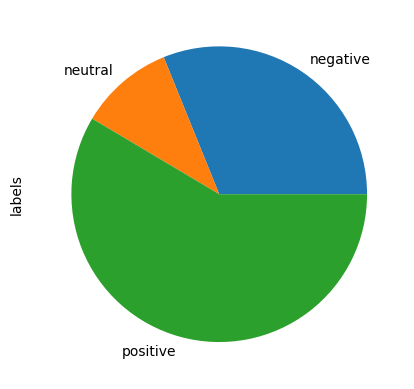

In [29]:
df_train.groupby('labels').labels.count().plot(kind='pie')


<AxesSubplot:xlabel='labels'>

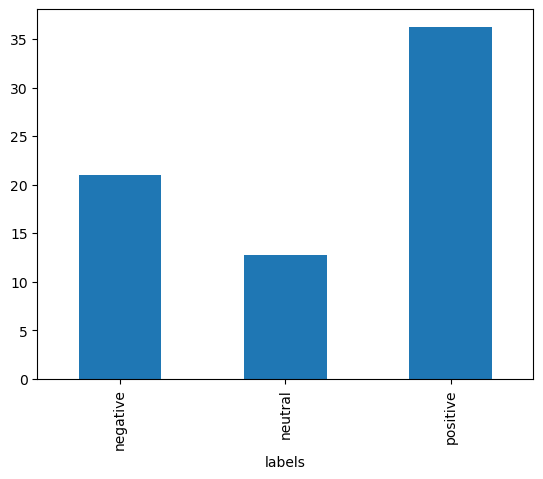

In [30]:
df_train.groupby('labels').total_word.mean().plot(kind='bar')


#### Histogram

Berikut contoh visualisasi Histogram untuk melihat persebaran jumlah word (total_word).



<AxesSubplot:>

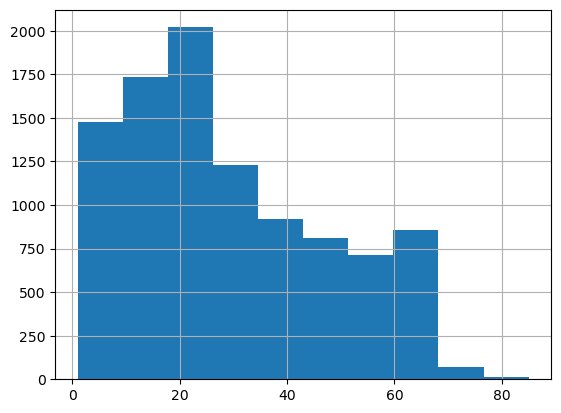

In [31]:
df_train.total_word.hist()


##### Histogram & Filter Sentiment

Kita bisa memfilter data berdasarkan sentimen setelah itu memvisualisasikannya dalam bentuk Histogram.


<AxesSubplot:>

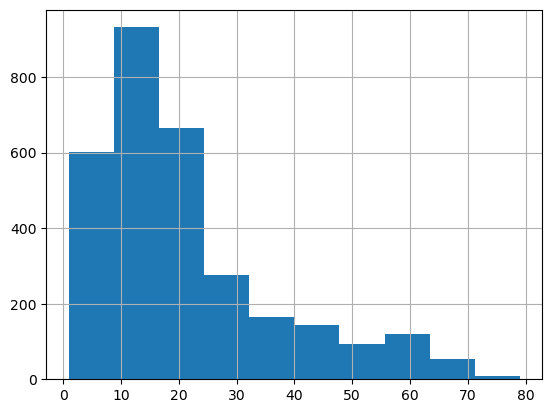

In [32]:
# misal visualisasi hanya berdasarkan sentimen negatif 
df_negative = df_train.loc[df_train['labels'] == 'negative']
df_negative['total_word'].hist()

<AxesSubplot:>

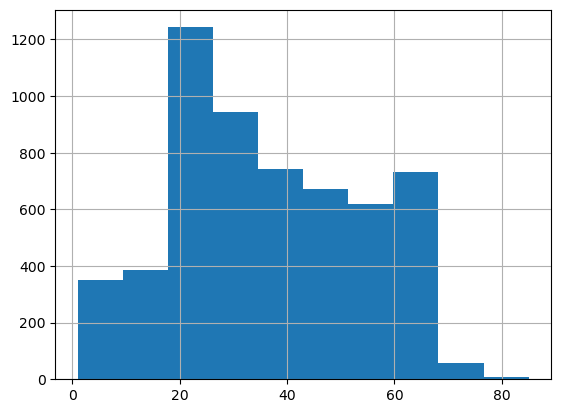

In [33]:
# misal visualisasi hanya berdasarkan sentimen positive
df_positive = df_train.loc[df_train['labels'] == 'positive']
df_positive['total_word'].hist()

<AxesSubplot:>

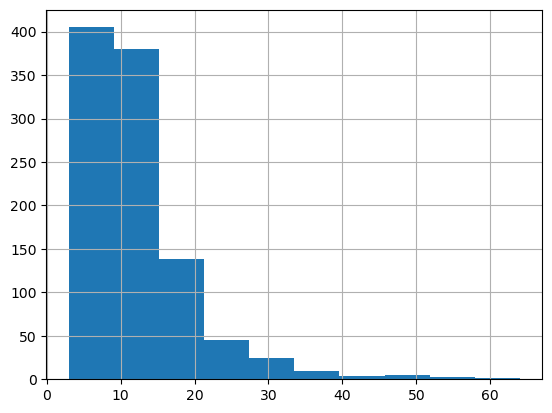

In [34]:
# misal visualisasi hanya berdasarkan sentimen neutral
df_neutral = df_train.loc[df_train['labels'] == 'neutral']
df_neutral['total_word'].hist()

#### Wordcloud


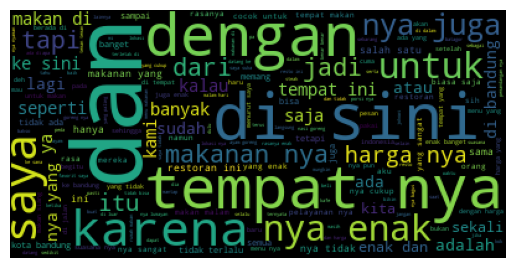

In [35]:
# Visualisasi Wordcloud

from wordcloud import WordCloud
text = ' '.join(df_train['tweets'])
wordcloud = WordCloud().generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

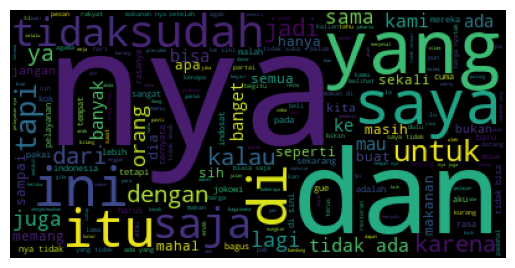

In [36]:
# Visualisasi Wordcloud sentiment negative 
# wordclod based on negative sentiment
df_negative = df_train.loc[df_train['labels'] == 'negative']

text = ' '.join(df_negative['tweets'])
wordcloud = WordCloud().generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [37]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_negative['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 2078), ('tidak', 1732), ('yang', 1531), ('dan', 1129), ('di', 1063), ('saya', 967), ('ini', 694), ('saja', 593), ('dengan', 575), ('itu', 550)]


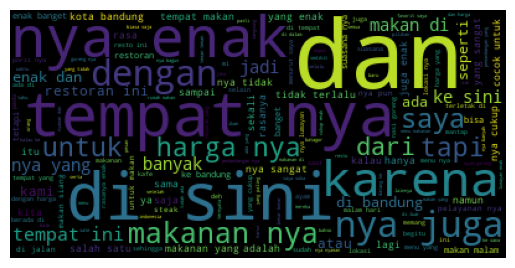

In [38]:
# Visualisasi Wordcloud sentiment positive 
# wordclod based on positive sentiment
df_positive = df_train.loc[df_train['labels'] == 'positive']

text = ' '.join(df_positive['tweets'])
wordcloud = WordCloud().generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [39]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_positive['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('nya', 9866), ('yang', 6615), ('dan', 5807), ('di', 5582), ('enak', 3142), ('dengan', 2897), ('tempat', 2874), ('makanan', 2857), ('saya', 2805), ('untuk', 2454)]


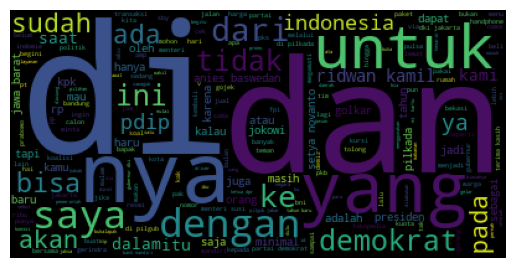

In [40]:
# Visualisasi Wordcloud sentiment negative 
# wordclod based on negative sentiment
df_neutral = df_train.loc[df_train['labels'] == 'neutral']

text = ' '.join(df_neutral['tweets'])
wordcloud = WordCloud().generate(text)

# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [41]:
# determine the word from df_train['tweet_without_stopwords'] that occurs frequently
import nltk
text = ' '.join(df_neutral['tweets'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))

[('di', 305), ('dan', 194), ('yang', 186), ('nya', 184), ('untuk', 135), ('dengan', 121), ('saya', 119), ('demokrat', 90), ('ke', 81), ('tidak', 79)]


# Modeling

In [42]:
def cleansing(text):
    # Make sentence being lowercase
    text = text.lower()

    # Remove user, rt, \n, retweet, \t, url, xd
    pattern_1 = r'(user|retweet|\\t|\\r|url|xd)'
    text = re.sub(pattern_1, '', text)

    # Remove mention
    pattern_2 = r'@[^\s]+'
    text = re.sub(pattern_2, '', text)

    # Remove hashtag
    pattern_3 = r'#([^\s]+)'
    text = re.sub(pattern_3, '', text)

    # Remove general punctuation, math operation char, etc.
    pattern_4 = r'[\,\@\*\_\-\!\:\;\?\'\.\"\)\(\{\}\<\>\+\%\$\^\#\/\`\~\|\&\|]'
    text = re.sub(pattern_4, ' ', text)

    # Remove single character
    pattern_5 = r'\b\w{1,1}\b'
    text = re.sub(pattern_5, '', text)

    # Remove emoji
    pattern_6 = r'\\[a-z0-9]{1,5}'
    text = re.sub(pattern_6, '', text)

    # Remove digit character
    pattern_7 = r'\d+'
    text = re.sub(pattern_7, '', text)

    # Remove url start with http or https
    pattern_8 = r'(https|https:)'
    text = re.sub(pattern_8, '', text)

    # Remove (\); ([); (])
    pattern_9 = r'[\\\]\[]'
    text = re.sub(pattern_9, '', text)

    # Remove character non ASCII
    pattern_10 = r'[^\x00-\x7f]'
    text = re.sub(pattern_10, '', text)

    # Remove character non ASCII
    pattern_11 = r'(\\u[0-9A-Fa-f]+)'
    text = re.sub(pattern_11, '', text)

    # Remove multiple whitespace
    pattern_12 = r'(\s+|\\n)'
    text = re.sub(pattern_12, ' ', text)
    
    # Remove whitespace at the first and end sentences
    text = text.rstrip()
    text = text.lstrip()

    # Pattern to look for three or more repetitions of any character, including newlines.
    pattern_13 = re.compile(r"(.)\1{1,}", re.DOTALL)
    text = re.sub(pattern_13, r"\1\1", text)
    return text

def tokenisasi(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [43]:
df_train['clean_tweets'] = df_train['tweets'].apply(cleansing)
df_test['clean_tweets'] = df_test['tweets'].apply(cleansing)

## Feature Engineering

In [44]:
df_train['word_tokens'] = df_train['clean_tweets'].apply(tokenisasi)
df_test['word_tokens'] = df_test['clean_tweets'].apply(tokenisasi)

In [45]:
df_train[['clean_tweets']][0:10]

,clean_tweets
0,tempat yang nyaman untuk berkumpul dengan tema...
1,memang banyak bacot sih omongan doang gede boc...
2,buat yang berkunjung ke bandung yang ingin men...
3,restoran menyajikan makanan khas sunda yang en...
4,kalau travelling ke bandung wajib makan batago...
5,mengurus kampung menata kota demiz demul ahli nya
6,menyajikan aneka macam ikan bakar disajikan de...
7,terletak di jalan cipaganti bandung di seberan...
8,jokowi adalah satu satunya presiden yang tidak...
9,alhamdulillah


## One Hot Encoding

In [46]:
le = LabelEncoder()

df_train['label_encode'] = le.fit_transform(df_train['labels'])
df_test['label_encode'] = le.transform(df_test['labels'])

display(df_train.head())

print(df_train.dtypes)

,tweets,labels,total_word,clean_tweets,word_tokens,label_encode
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,31,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2
1,memang banyak bacot sih omongan doang gede boc...,negative,33,memang banyak bacot sih omongan doang gede boc...,"[memang, banyak, bacot, sih, omongan, doang, g...",0
2,buat yang berkunjung ke bandung yang ingin men...,positive,38,buat yang berkunjung ke bandung yang ingin men...,"[buat, yang, berkunjung, ke, bandung, yang, in...",2
3,restoran menyajikan makanan khas sunda yang en...,positive,33,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2
4,kalau travelling ke bandung wajib makan batago...,positive,39,kalau travelling ke bandung wajib makan batago...,"[kalau, travelling, ke, bandung, wajib, makan,...",2


tweets          object
labels          object
total_word       int64
clean_tweets    object
word_tokens     object
label_encode     int32
dtype: object


In [47]:
df_train.isna().sum()

tweets          0
labels          0
total_word      0
clean_tweets    0
word_tokens     0
label_encode    0
dtype: int64

In [48]:
# Menggabungkan setiap elemen dalam kolom 'word_tokens' menjadi satu string
df_train['string_tokens'] = df_train['word_tokens'].apply(' '.join)

In [49]:
df_train

,tweets,labels,total_word,clean_tweets,word_tokens,label_encode,string_tokens
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,31,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2,tempat yang nyaman untuk berkumpul dengan tema...
1,memang banyak bacot sih omongan doang gede boc...,negative,33,memang banyak bacot sih omongan doang gede boc...,"[memang, banyak, bacot, sih, omongan, doang, g...",0,memang banyak bacot sih omongan doang gede boc...
2,buat yang berkunjung ke bandung yang ingin men...,positive,38,buat yang berkunjung ke bandung yang ingin men...,"[buat, yang, berkunjung, ke, bandung, yang, in...",2,buat yang berkunjung ke bandung yang ingin men...
3,restoran menyajikan makanan khas sunda yang en...,positive,33,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2,restoran menyajikan makanan khas sunda yang en...
4,kalau travelling ke bandung wajib makan batago...,positive,39,kalau travelling ke bandung wajib makan batago...,"[kalau, travelling, ke, bandung, wajib, makan,...",2,kalau travelling ke bandung wajib makan batago...
...,...,...,...,...,...,...,...
9894,tiap kegaduhan melanda presiden sowan ke prabo...,negative,18,tiap kegaduhan melanda presiden sowan ke prabo...,"[tiap, kegaduhan, melanda, presiden, sowan, ke...",0,tiap kegaduhan melanda presiden sowan ke prabo...
9895,warung nasi ampera memiliki konsep rumah makan...,positive,45,warung nasi ampera memiliki konsep rumah makan...,"[warung, nasi, ampera, memiliki, konsep, rumah...",2,warung nasi ampera memiliki konsep rumah makan...
9896,mbak della sangat baik dan ramah makanna nya j...,positive,43,mbak della sangat baik dan ramah makanna nya j...,"[mbak, della, sangat, baik, dan, ramah, makann...",2,mbak della sangat baik dan ramah makanna nya j...
9897,suasana nya sangat romantis jika makan malam d...,positive,47,suasana nya sangat romantis jika makan malam d...,"[suasana, nya, sangat, romantis, jika, makan, ...",2,suasana nya sangat romantis jika makan malam d...


## Cek kata-kata dalam data frame yang tergolong ke dalam Outlier

[('nya', 12128), ('yang', 8332), ('dan', 7130), ('di', 6950), ('tidak', 3908), ('saya', 3891), ('dengan', 3593), ('enak', 3373), ('makanan', 3213), ('ini', 3192)]
[('tamarkan', 1), ('hasyim', 1), ('abiz', 1), ('nonstop', 1), ('cooker', 1), ('lintong', 1), ('sidikkalang', 1), ('beverages', 1), ('macchiato', 1), ('con', 1), ('pana', 1), ('milkshakes', 1), ('dikebanyakan', 1), ('sebong', 1), ('ganyadar', 1), ('euforia', 1), ('kebobolan', 1), ('temap', 1), ('cushion', 1), ('pillow', 1), ('heheheh', 1), ('pascabayar', 1), ('lagoon', 1), ('bingitts', 1), ('redtoran', 1), ('lamgsung', 1), ('menhadap', 1), ('afa', 1), ('penyisihan', 1), ('mojok', 1), ('lagee', 1), ('muantab', 1), ('suprisingly', 1), ('expensive', 1), ('husein', 1), ('chatuchak', 1), ('jusan', 1), ('teruskanlah', 1), ('kichen', 1), ('hadap', 1), ('nasrani', 1), ('bencilah', 1), ('tip', 1), ('great', 1), ('unduh', 1), ('boejangan', 1), ('kesampean', 1), ('endues', 1), ('pirimg', 1), ('lpm', 1), ('masakah', 1), ('muslimah', 1), (

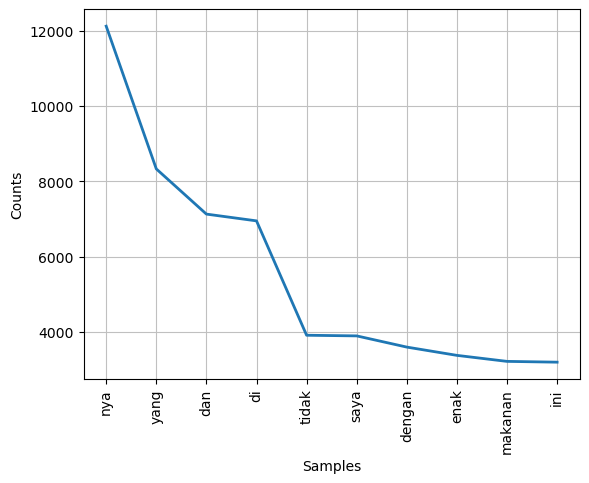

In [50]:
# determine the word from df['tweet_without_stopwords'] that occurs frequently
text = ' '.join(df_train['string_tokens'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))
print(freq_kata.most_common()[-1000:]) # 10 kata paling sedikit muncul
freq_kata.plot(10, cumulative=False)
plt.show()

In [51]:
# get the frequency distribution of words
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))

# calculate the interquartile range (IQR) of word frequency
q1, q3 = np.percentile(list(freq_kata.values()), [1, 99])
iqr = q3 - q1

# calculate the upper and lower bounds for outliers
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# get the words that are outliers
outliers = [word for word, freq in freq_kata.items() if freq > upper_bound or freq < lower_bound]
print(outliers)

['tempat', 'yang', 'nyaman', 'untuk', 'dengan', 'ada', 'kalau', 'malam', 'cukup', 'enak', 'di', 'jalan', 'harga', 'banyak', 'ke', 'rasanya', 'itu', 'seperti', 'buat', 'bandung', 'tidak', 'nya', 'dan', 'makan', 'restoran', 'ini', 'menu', 'sangat', 'makanan', 'rasa', 'saya', 'tapi', 'banget', 'nasi', 'ayam', 'goreng', 'juga', 'adalah', 'bisa', 'pelayanan', 'saja', 'dari', 'suasana', 'pemandangan', 'lebih', 'bagus', 'sini', 'sudah', 'kami', 'karena', 'kita', 'suka', 'orang', 'sekali', 'jadi', 'sama']


In [52]:
# define a function to remove words from DataFrame
def remove_outliers(row):
    words = row['string_tokens'].split()
    words = [word for word in words if word not in outliers]
    return ' '.join(words)

# apply the function to the DataFrame
df_train['clean_string'] = df_train.apply(remove_outliers, axis=1)

In [53]:
df_train

,tweets,labels,total_word,clean_tweets,word_tokens,label_encode,string_tokens,clean_string
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,31,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2,tempat yang nyaman untuk berkumpul dengan tema...,berkumpul teman teman lagu lumayan kadang proy...
1,memang banyak bacot sih omongan doang gede boc...,negative,33,memang banyak bacot sih omongan doang gede boc...,"[memang, banyak, bacot, sih, omongan, doang, g...",0,memang banyak bacot sih omongan doang gede boc...,memang bacot sih omongan doang gede bocah mema...
2,buat yang berkunjung ke bandung yang ingin men...,positive,38,buat yang berkunjung ke bandung yang ingin men...,"[buat, yang, berkunjung, ke, bandung, yang, in...",2,buat yang berkunjung ke bandung yang ingin men...,berkunjung ingin mencoba masakan padang salah ...
3,restoran menyajikan makanan khas sunda yang en...,positive,33,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2,restoran menyajikan makanan khas sunda yang en...,menyajikan khas sunda terutama gurami terbang ...
4,kalau travelling ke bandung wajib makan batago...,positive,39,kalau travelling ke bandung wajib makan batago...,"[kalau, travelling, ke, bandung, wajib, makan,...",2,kalau travelling ke bandung wajib makan batago...,travelling wajib batagor riri waktu cabang pas...
...,...,...,...,...,...,...,...,...
9894,tiap kegaduhan melanda presiden sowan ke prabo...,negative,18,tiap kegaduhan melanda presiden sowan ke prabo...,"[tiap, kegaduhan, melanda, presiden, sowan, ke...",0,tiap kegaduhan melanda presiden sowan ke prabo...,tiap kegaduhan melanda presiden sowan prabowo ...
9895,warung nasi ampera memiliki konsep rumah makan...,positive,45,warung nasi ampera memiliki konsep rumah makan...,"[warung, nasi, ampera, memiliki, konsep, rumah...",2,warung nasi ampera memiliki konsep rumah makan...,warung ampera memiliki konsep rumah prasmanan ...
9896,mbak della sangat baik dan ramah makanna nya j...,positive,43,mbak della sangat baik dan ramah makanna nya j...,"[mbak, della, sangat, baik, dan, ramah, makann...",2,mbak della sangat baik dan ramah makanna nya j...,mbak della baik ramah makanna minuman indah te...
9897,suasana nya sangat romantis jika makan malam d...,positive,47,suasana nya sangat romantis jika makan malam d...,"[suasana, nya, sangat, romantis, jika, makan, ...",2,suasana nya sangat romantis jika makan malam d...,romantis jika benar benar eksterior interior l...


In [54]:
df_train['clean_string_tokens'] = df_train['clean_string'].apply(tokenisasi)

In [55]:
# define a function to count the number of words in a string
def count_words(text):
    words = text.split()
    return len(words)

# apply the function to the DataFrame
df_train['num_words'] = df_train['clean_string'].apply(count_words)

# calculate the average number of words per row
avg_words = df_train['num_words'].mean()

print("Average number of words per row: ", avg_words)

Average number of words per row:  17.496646341463414


In [72]:
df_train_copy = df_train.copy()

## LSTM

Preprocessing Data

In [73]:
MAX_NB_WORDS = 15000
MAX_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 100

In [75]:
# Split data train
X_train, X_val, Y_train, Y_val = train_test_split(df_train_copy['clean_string'], df_train_copy['labels'], test_size=0.10, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(8856,) (8856,)
(984,) (984,)


In [67]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

In [77]:
X_train

5835    batagor simpang dago menawarkan masakan khas i...
7360    halo triliun mau tanya kenapa butuh menunggu j...
6670    sebenarnya bukan agak kecewa sih kecewa kinerj...
8124    apa pun yanga diresto dimulai sarapan siang sa...
8649    pesan lasagna fish chips kedengeran biasa teta...
                              ...                        
5753    fahri hamzonk ketua mulut nyinyir mulut bangka...
5208    beredar isu azwar anas mundur sebagai cawagub ...
5407    yoshinoya pasti beli rice bowl daging sapi men...
860     kasihan anak sekarang hari minggu menonton kartun
7299    sosis lezat aneka olahan kentang pun mantap st...
Name: clean_string, Length: 8856, dtype: object

In [78]:
tokenizer.fit_on_texts(X_train)

# Tokenisasi data train
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
Y_train = pd.get_dummies(Y_train).values

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
Y_val = pd.get_dummies(Y_val).values

# Tokenisasi data test
X_test = tokenizer.texts_to_sequences(df_test['clean_tweets'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
Y_test = pd.get_dummies(df_test['label_encode']).values

In [79]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Balancing Data

In [81]:
# inisiasi RandomOverSampler
ros = RandomOverSampler(random_state=42)

# lakukan oversampling pada kolom "tweets" dan "labels" dengan memanggil fungsi fit_resample()
X_resampled, y_resampled = ros.fit_resample(X_train, Y_train)

In [82]:
# Membuat model LSTM
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

epochs = 50
batch_size = 64

# Training model
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[es])

Epoch 1/50
125/125 [==============================] - 30s 190ms/step - loss: 0.7330 - accuracy: 0.7009 - val_loss: 0.5570 - val_accuracy: 0.7686
Epoch 2/50
125/125 [==============================] - 23s 182ms/step - loss: 0.3832 - accuracy: 0.8526 - val_loss: 0.4331 - val_accuracy: 0.8397
Epoch 3/50
125/125 [==============================] - 21s 171ms/step - loss: 0.2057 - accuracy: 0.9355 - val_loss: 0.4806 - val_accuracy: 0.8341
Epoch 4/50
125/125 [==============================] - 21s 172ms/step - loss: 0.1212 - accuracy: 0.9641 - val_loss: 0.5092 - val_accuracy: 0.8239
Epoch 5/50
125/125 [==============================] - 23s 183ms/step - loss: 0.0870 - accuracy: 0.9719 - val_loss: 0.5918 - val_accuracy: 0.8217
Epoch 6/50
125/125 [==============================] - 27s 214ms/step - loss: 0.0636 - accuracy: 0.9795 - val_loss: 0.6662 - val_accuracy: 0.8239
Epoch 7/50
125/125 [==============================] - 24s 192ms/step - loss: 0.0595 - accuracy: 0.9789 - val_loss: 0.6842 - val_ac

### Validation

In [92]:
y_pred = model.predict(X_val)
y_pred.shape

31/31 [==============================] - 1s 20ms/step


(984, 3)

In [93]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
accuracy = accuracy_score(Y_val_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.22%


In [94]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
print(classification_report(Y_val_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       297
           1       0.68      0.63      0.66       100
           2       0.89      0.86      0.88       587

    accuracy                           0.82       984
   macro avg       0.77      0.77      0.77       984
weighted avg       0.82      0.82      0.82       984



### Predict data test

In [95]:
y_pred = model.predict(X_test)
y_pred.shape

35/35 [==============================] - 1s 18ms/step


(1100, 3)

In [96]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.64%


In [97]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       353
           1       0.73      0.67      0.70       121
           2       0.88      0.89      0.88       626

    accuracy                           0.83      1100
   macro avg       0.79      0.78      0.78      1100
weighted avg       0.83      0.83      0.83      1100



In [98]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[353 111 636]


In [99]:
y_pred_sentiment = y_pred.argmax(axis=-1)

# konversi nilai prediksi menjadi label sentimen
labels = {0: "negative", 1: "neutral", 2: "positive"}
df_test["label_prediksi"] = [labels[pred] for pred in y_pred_sentiment]

In [100]:
df_test

,tweets,labels,clean_tweets,word_tokens,label_encode,label_prediksi
0,nasi liwet asep stroberi yang terletak di jala...,positive,nasi liwet asep stroberi yang terletak di jala...,"[nasi, liwet, asep, stroberi, yang, terletak, ...",2,positive
1,tolong dipercepat lagi pengiriman nya,negative,tolong dipercepat lagi pengiriman nya,"[tolong, dipercepat, lagi, pengiriman, nya]",0,negative
2,handphone saya lenovo kecemplung di comberan p...,positive,handphone saya lenovo kecemplung di comberan p...,"[handphone, saya, lenovo, kecemplung, di, comb...",2,positive
3,ini suki and barbeque versi murah meriah lumay...,positive,ini suki and barbeque versi murah meriah lumay...,"[ini, suki, and, barbeque, versi, murah, meria...",2,positive
4,mau melihat bandung dari atas nah ini tempat n...,positive,mau melihat bandung dari atas nah ini tempat n...,"[mau, melihat, bandung, dari, atas, nah, ini, ...",2,positive
...,...,...,...,...,...,...
1095,mau petik stroberi nya tetapi ternyata sedang ...,positive,mau petik stroberi nya tetapi ternyata sedang ...,"[mau, petik, stroberi, nya, tetapi, ternyata, ...",2,positive
1096,yang benar saja masa nomer whatsapp saya di bl...,negative,yang benar saja masa nomer whatsapp saya di bl...,"[yang, benar, saja, masa, nomer, whatsapp, say...",0,negative
1097,food court yang memiliki berbagai macam piliha...,positive,food court yang memiliki berbagai macam piliha...,"[food, court, yang, memiliki, berbagai, macam,...",2,positive
1098,gorengan basi dihidangkan selera murahan,negative,gorengan basi dihidangkan selera murahan,"[gorengan, basi, dihidangkan, selera, murahan]",0,negative


## Save Model

In [101]:
model.save("sentiment_analysis_model_challenge.h5")

## Cara menggunakan model kembali dengan load model

In [102]:
# load data baru
df_new = pd.read_csv("test_data.csv")
df_new = df_new.applymap(cleansing)
# df_new = df_new.applymap(remove_stopwords)

sentences = df_new['tweets']
df_new['label_encoded'] = le.transform(df_new['labels'])
df_new_labels = pd.get_dummies(df_new['label_encoded']).values

# lakukan preprocessing pada data baru
X_new = tokenizer.texts_to_sequences(sentences)
X_new = pad_sequences(X_new, maxlen=MAX_SEQUENCE_LENGTH)

loaded_model = load_model("sentiment_analysis_model_challenge.h5")

# lakukan prediksi pada data baru
y_prob = loaded_model.predict(X_new)
y_pred = y_prob.argmax(axis=-1)

# konversi nilai prediksi menjadi label sentimen
labels = {0: "negative", 1: "neutral", 2: "positive"}
df_new["label_sentimen"] = [labels[pred] for pred in y_pred]

35/35 [==============================] - 2s 22ms/step


### Cek akurasi prediksi label terhadap label original

In [103]:
y_pred_classes = np.argmax(y_prob, axis=1)
Y_val_classes = np.argmax(df_new_labels, axis=1)
accuracy = accuracy_score(Y_val_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.64%


In [104]:
y_pred_classes = np.argmax(y_prob, axis=1)
Y_test_classes = np.argmax(df_new_labels, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       353
           1       0.73      0.67      0.70       121
           2       0.88      0.89      0.88       626

    accuracy                           0.83      1100
   macro avg       0.79      0.78      0.78      1100
weighted avg       0.83      0.83      0.83      1100



In [105]:
df_new.label_sentimen.value_counts()

positive    636
negative    353
neutral     111
Name: label_sentimen, dtype: int64

In [106]:
df_new

,tweets,labels,label_encoded,label_sentimen
0,nasi liwet asep stroberi yang terletak di jala...,positive,2,positive
1,tolong dipercepat lagi pengiriman nya,negative,0,negative
2,handphone saya lenovo kecemplung di comberan p...,positive,2,positive
3,ini suki and barbeque versi murah meriah lumay...,positive,2,positive
4,mau melihat bandung dari atas nah ini tempat n...,positive,2,positive
...,...,...,...,...
1095,mau petik stroberi nya tetapi ternyata sedang ...,positive,2,positive
1096,yang benar saja masa nomer whatsapp saya di bl...,negative,0,negative
1097,food court yang memiliki berbagai macam piliha...,positive,2,positive
1098,gorengan basi dihidangkan selera murahan,negative,0,negative


# CNN

In [79]:
# Load data
#data = pd.read_csv("train_preprocess.tsv.txt", sep="\t", engine="python", names=["data", "label"])
sentences = df_train_copy['clean_string']
labels = df_train_copy['label_encode']

# Convert labels to numeric values
#label_dict = {"negative": 0, "neutral": 1, "positive": 2}
#labels = np.array([label_dict[label] for label in labels])
#labels = np.array([labels])

# Tokenize data
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=64)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, labels, test_size=0.2)

# One-hot encode the labels
Y_train = tf.keras.utils.to_categorical(Y_train, 3)
Y_test = tf.keras.utils.to_categorical(Y_test, 3)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=64),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 2
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/2
432/432 [==============================] - 21s 41ms/step - loss: 0.4503 - accuracy: 0.8137 - val_loss: 0.1978 - val_accuracy: 0.9314
Epoch 2/2
432/432 [==============================] - 20s 46ms/step - loss: 0.0958 - accuracy: 0.9664 - val_loss: 0.1823 - val_accuracy: 0.9384
108/108 - 1s - loss: 0.1823 - accuracy: 0.9384 - 534ms/epoch - 5ms/step
Test accuracy: 0.9383680820465088


In [80]:
model.save("sentiment_analysis_model_CNN_challenge.h5")

# Feed Forward Neural Network

In [126]:
# define model
model = Sequential([
    Embedding(input_dim=15000, output_dim=128, input_length=64),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping callback
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# train model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[es])

# evaluate model
test_loss, test_acc = model.evaluate(X_val, Y_val)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/50
277/277 [==============================] - 18s 59ms/step - loss: 0.7397 - accuracy: 0.6698 - val_loss: 0.5326 - val_accuracy: 0.7764
Epoch 2/50
277/277 [==============================] - 16s 58ms/step - loss: 0.3813 - accuracy: 0.8554 - val_loss: 0.4141 - val_accuracy: 0.8557
Epoch 3/50
277/277 [==============================] - 14s 51ms/step - loss: 0.1594 - accuracy: 0.9500 - val_loss: 0.5008 - val_accuracy: 0.8486
Epoch 4/50
277/277 [==============================] - 12s 45ms/step - loss: 0.0651 - accuracy: 0.9758 - val_loss: 0.6051 - val_accuracy: 0.8476
Epoch 5/50
277/277 [==============================] - 13s 48ms/step - loss: 0.0420 - accuracy: 0.9857 - val_loss: 0.7530 - val_accuracy: 0.8404
Epoch 6/50
277/277 [==============================] - 14s 51ms/step - loss: 0.0337 - accuracy: 0.9863 - val_loss: 0.8439 - val_accuracy: 0.8384
Epoch 7/50
277/277 [==============================] - 13s 48ms/step - loss: 0.0305 - accuracy: 0.9857 - val_loss: 0.9645 - val_accuracy:

In [127]:
model.save("sentiment_analysis_feedForward_neuralNetwork.h5")

## Cek akurasi saat model digunakan pada data test_data.csv

In [128]:
X_test_ffnn = pd.read_csv("test_data.csv")

# preprocessing data
encoder = LabelEncoder()
X_test_ffnn['labels'] = le.transform(X_test_ffnn['labels'])
X_test_ffnn['tweets'] = X_test_ffnn['tweets'].apply(cleansing)

# tokenizing data
test_seq = tokenizer.texts_to_sequences(X_test_ffnn['tweets'])

# padding data
test_pad = pad_sequences(test_seq, maxlen=64)

# convert label to categorical
test_label = to_categorical(X_test_ffnn['labels'])

In [129]:
y_pred = model.predict(test_pad)
y_pred.shape

35/35 [==============================] - 1s 8ms/step


(1100, 3)

In [130]:
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.45%


In [131]:
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       353
           1       0.77      0.48      0.59       121
           2       0.86      0.91      0.89       626

    accuracy                           0.82      1100
   macro avg       0.80      0.73      0.75      1100
weighted avg       0.82      0.82      0.82      1100



In [132]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[365  75 660]


In [133]:
df_test.labels.value_counts()

positive    626
negative    353
neutral     121
Name: labels, dtype: int64

In [134]:
df_test.head()

,tweets,labels,clean_tweets,word_tokens,label_encode,label_prediksi
0,nasi liwet asep stroberi yang terletak di jala...,positive,nasi liwet asep stroberi yang terletak di jala...,"[nasi, liwet, asep, stroberi, yang, terletak, ...",2,positive
1,tolong dipercepat lagi pengiriman nya,negative,tolong dipercepat lagi pengiriman nya,"[tolong, dipercepat, lagi, pengiriman, nya]",0,negative
2,handphone saya lenovo kecemplung di comberan p...,positive,handphone saya lenovo kecemplung di comberan p...,"[handphone, saya, lenovo, kecemplung, di, comb...",2,positive
3,ini suki and barbeque versi murah meriah lumay...,positive,ini suki and barbeque versi murah meriah lumay...,"[ini, suki, and, barbeque, versi, murah, meria...",2,positive
4,mau melihat bandung dari atas nah ini tempat n...,positive,mau melihat bandung dari atas nah ini tempat n...,"[mau, melihat, bandung, dari, atas, nah, ini, ...",2,positive


## Menggunakan kembali model FFNN dengan load_model

In [135]:
X_test_ffnn = pd.read_csv("test_data.csv")

# preprocessing data
encoder = LabelEncoder()
X_test_ffnn['labels'] = le.transform(X_test_ffnn['labels'])
X_test_ffnn['tweets'] = X_test_ffnn['tweets'].apply(cleansing)

# tokenizing data
test_seq = tokenizer.texts_to_sequences(X_test_ffnn['tweets'])

# padding data
test_pad = pad_sequences(test_seq, maxlen=64)

# convert label to categorical
test_label = to_categorical(X_test_ffnn['labels'])

In [136]:
loaded_model_ffnn = load_model("sentiment_analysis_feedForward_neuralNetwork.h5")

In [137]:
y_pred = loaded_model_ffnn.predict(test_pad)
y_pred.shape

35/35 [==============================] - 0s 7ms/step


(1100, 3)

In [138]:
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.45%


In [139]:
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       353
           1       0.77      0.48      0.59       121
           2       0.86      0.91      0.89       626

    accuracy                           0.82      1100
   macro avg       0.80      0.73      0.75      1100
weighted avg       0.82      0.82      0.82      1100



In [140]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[365  75 660]


In [141]:
df_test.labels.value_counts()

positive    626
negative    353
neutral     121
Name: labels, dtype: int64

In [142]:
df_test.head()

,tweets,labels,clean_tweets,word_tokens,label_encode,label_prediksi
0,nasi liwet asep stroberi yang terletak di jala...,positive,nasi liwet asep stroberi yang terletak di jala...,"[nasi, liwet, asep, stroberi, yang, terletak, ...",2,positive
1,tolong dipercepat lagi pengiriman nya,negative,tolong dipercepat lagi pengiriman nya,"[tolong, dipercepat, lagi, pengiriman, nya]",0,negative
2,handphone saya lenovo kecemplung di comberan p...,positive,handphone saya lenovo kecemplung di comberan p...,"[handphone, saya, lenovo, kecemplung, di, comb...",2,positive
3,ini suki and barbeque versi murah meriah lumay...,positive,ini suki and barbeque versi murah meriah lumay...,"[ini, suki, and, barbeque, versi, murah, meria...",2,positive
4,mau melihat bandung dari atas nah ini tempat n...,positive,mau melihat bandung dari atas nah ini tempat n...,"[mau, melihat, bandung, dari, atas, nah, ini, ...",2,positive
